In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [120]:
%cd "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/RNN/IMDB-sentiment-classification"

/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/RNN/IMDB-sentiment-classification


In [6]:
!pip install pyyaml h5py

In [129]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Embedding, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [124]:
file_prefix = %pwd

In [102]:
max_vocab = 10000 # maximum number of words in vocab; None = no maximum
max_length = 200 # maximum length for each sequence; None = variable length
hidden_dimension = 5 # hidden dimension for RNN
embedding_dimension = 20 # embedding dimension
batch_size = 32 # batch size for Adam
epochs = 10
learning_rate = 0.001

In [132]:
def loss_accuracy_plot(history):
  fig = plt.figure(figsize = (8,10))
  ax1 = plt.subplot(2,1,1)
  plt.plot(history["loss"], color = "blue", label = "training loss")
  plt.plot(history["val_loss"], color = "orange", label = "validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  ax2 = plt.subplot(2,1,2)
  plt.plot(history["accuracy"], color = "blue", label = "training accuracy")
  plt.plot(history["val_accuracy"], color = "orange", label = "validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()
  return (fig, ax1, ax2)

In [103]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = max_vocab)
if max_length is not None:
  X_train = pad_sequences(X_train, maxlen = max_length)
  X_test = pad_sequences(X_test, maxlen = max_length)

In [93]:
word_index = imdb.get_word_index()
token_index = {value: key for (key, value) in word_index.items()}
def get_review(token_sequence):
  return " ".join(token_index[token] for token in token_sequence if token != 0)

In [94]:
get_review(X_train[100])

"the was rather is him completely br english send to one dvd for kind way are year type but tired talent of am stories slightest coop on her no was although some has as was garbage che's that to to when it as if is herself br and door simply to picture 25 for he silent to holy dramatically to bigger reason was then does sorry very not reason as it out is herself br film's for with and are of tension 4 of human br english send in could is again outrageous movies episode we could that elements for was nothing laugh has of holy laughing lot not me in perfect and of totally most only dreary 2 one an this an as it is fight harry storyline to action much one out will half this of and setting place movie is guide was fight wonderful have then zombies man sense are as am some br didn't"

In [108]:
def RNN_model(max_length, max_vocab, hidden_dimension, embedding_dimension, batch_size, learning_rate):
  input = Input(shape = (max_length,), dtype = tf.int32)
  if max_vocab is not None:
    embedding = Embedding(input_dim = max_vocab,
                          output_dim = embedding_dimension,
                          mask_zero = True)(input)
  else:
      embedding = Embedding(input_dim = len(word_index),
                            output_dim = embedding_dimension,
                            mask_zero = True)(input)
  dropout = Dropout(0.2)(embedding)
  rnn = SimpleRNN(hidden_dimension,
                  activation = "tanh")(dropout)
  dense = Dense(1, activation = "sigmoid")(rnn)
  model = Model(inputs = input, outputs = dense)
  adam = Adam(learning_rate = learning_rate)
  model.compile(optimizer = adam,
                loss = "binary_crossentropy",
                metrics = ["accuracy"])
  return model

In [110]:
model = RNN_model(max_length, max_vocab, hidden_dimension, embedding_dimension, batch_size, learning_rate)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 200, 20)        │        200,000 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 200, 20)        │              0 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_8 (NotEqual)    │ (None, 200)            │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_8 (SimpleRNN)  │ (None, 5)              │            130 │ dropout_8[0][0],       │
│                           │                        │                │ not_equal_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │              6 │ simple_rnn_8[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 200,136 (781.78 KB)

 Trainable params: 200,136 (781.78 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
# define callback to save model checkpoints
checkpoint_path = file_prefix + "/checkpoints/rnn1.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

In [126]:
history = model.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_split = 0.3,
                    callbacks = [cp_callback])

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5528 - loss: 0.6835
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/RNN/IMDB-sentiment-classification/checkpoints/rnn1.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 54s 90ms/step - accuracy: 0.5528 - loss: 0.6835 - val_accuracy: 0.6287 - val_loss: 0.6327
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7361 - loss: 0.5354
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/RNN/IMDB-sentiment-classification/checkpoints/rnn1.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.7361 - loss: 0.5353 - val_accuracy: 0.7943 - val_loss: 0.4701
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8474 - loss: 0.3715
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portf

In [130]:
# save history dictionary in case we have to restart notebook
savepath = file_prefix + "/checkpoints/rnn1_history.json"
with open(savepath, "w") as f:
  json.dump(history.history, f, indent = 4)

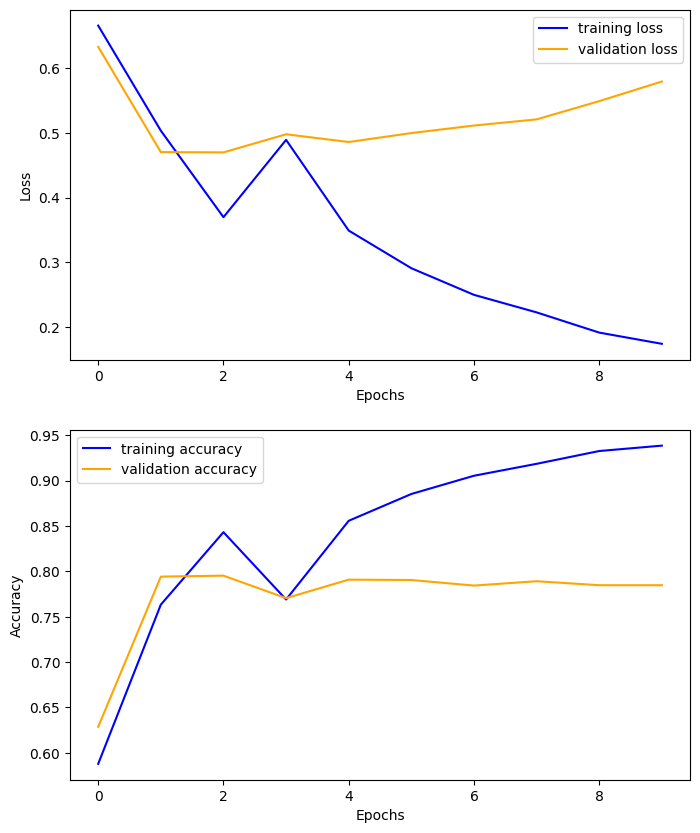

(<Figure size 800x1000 with 2 Axes>,
 <Axes: xlabel='Epochs', ylabel='Loss'>,
 <Axes: xlabel='Epochs', ylabel='Accuracy'>)

In [133]:
savepath = file_prefix + "/checkpoints/rnn1_history.json"
with open(savepath, "r") as f:
  history = json.load(f)
loss_accuracy_plot(history)